### Bibliotecas

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb

from scipy import stats
import itertools

from copy import deepcopy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Lendo Dados

In [25]:
df = pd.read_csv('./Data/volve_preproc.csv')
df.shape

(23733, 10)

#### Filtering Data

In [27]:
n=4
df2 = df[::n]
df2.shape

(5934, 10)

```
Importante: dropando DT para treinar com mais dados
```

In [28]:
df2 = df2.drop(['DT'], axis=1)
df2.shape

(5934, 9)

In [29]:
df_filt = df2.dropna()
df_filt.shape

(5913, 9)

In [30]:
df.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,2099,2099,2099,2099,2099,2099,2099,2099,2099
15/9-F-1 B,1903,1903,1903,1903,1903,1903,1903,1903,1903
15/9-F-1 C,7631,7631,0,7631,7631,7631,7630,7630,7631
15/9-F-11 A,1402,1402,1402,1402,1402,1402,1321,1321,1402
15/9-F-11 B,10698,10698,0,10698,10698,10698,10698,10698,10698


In [31]:
df2.groupby('wellName').count()

,MD,CALI,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,
15/9-F-1 A,525,525,525,525,525,525,525,525
15/9-F-1 B,476,476,476,476,476,476,476,476
15/9-F-1 C,1908,1908,1908,1908,1908,1908,1908,1908
15/9-F-11 A,350,350,350,350,350,329,329,350
15/9-F-11 B,2675,2675,2675,2675,2675,2675,2675,2675


In [32]:
df_filt.groupby('wellName').count()

,MD,CALI,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,
15/9-F-1 A,525,525,525,525,525,525,525,525
15/9-F-1 B,476,476,476,476,476,476,476,476
15/9-F-1 C,1908,1908,1908,1908,1908,1908,1908,1908
15/9-F-11 A,329,329,329,329,329,329,329,329
15/9-F-11 B,2675,2675,2675,2675,2675,2675,2675,2675


### Treinando modelo de ML para prever GR

#### Definindo a parcela de treino e de teste

In [33]:
training_wells = ['15/9-F-1 A', '15/9-F-1 B', '15/9-F-11 B', '15/9-F-11 A']
test_wells = ['15/9-F-1 C']
nodata_wells = ['15/9-F-11 B', '15/9-F-1 C'] #poços sem a informação de DT

In [34]:
train_df = df_filt[df_filt['wellName'].isin(training_wells)]
test_df = df_filt[df_filt['wellName'].isin(test_wells)]
nodata_df = df_filt[df_filt['wellName'].isin(nodata_wells)]

#### Selecionando variáveis de entrada e saída

In [35]:
inputs = [
    'CALI',
    # 'DT',
    # 'GR',
    'NPHI',
    'RHOB',
    'PHIF',
    # 'SW',
    'RACEHM_LOG'
    ]
output = ['GR']

In [38]:
X_tr.shape,y_tr.shape,X_te.shape,y_te.shape

((4005, 5), (4005, 1), (1908, 5), (1908, 1))

In [39]:
X_tr = X_tr.values
X_te = X_te.values
y_tr = y_tr.values
y_te = y_te.values

#### Normalizando dados MinMax

In [40]:
Xtr_scaler = StandardScaler()
ytr_scaler = StandardScaler()
Xte_scaler = StandardScaler()
yte_scaler = StandardScaler()
X_tr = Xtr_scaler.fit_transform(X_tr)
X_te = Xte_scaler.fit_transform(X_te)
y_tr = ytr_scaler.fit_transform(y_tr)
y_te = yte_scaler.fit_transform(y_te)

Random State

In [41]:
rs=48

#### Declarando os Modelos ML

In [48]:
models_ml = [
    ('Linear'   ,'LinReg'              ,      LinearRegression(copy_X=True)), #ARX Equivalet
    ('NonLinear','PolyReg'             ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivale)t
    # ('NonLinear','SVM'                 ,      SVR(max_iter=-1)),
    ('NonLinear','KNN'                 ,      KNeighborsRegressor()),
    ('NonLinear','MLP'                 ,      MLPRegressor(random_state=rs)),
    ('Ensembles','DecisionTree'        ,      DecisionTreeRegressor(random_state=rs)),
    ('Ensembles','RandomForest'        ,      RandomForestRegressor(random_state=rs)),
    ('Ensembles','GradientBoosting'    ,      GradientBoostingRegressor(random_state=rs)),
    ('Ensembles','ExtraTrees'          ,      ExtraTreesRegressor(random_state=rs)),
    ('Ensembles','AdaBoostRegressor'   ,      AdaBoostRegressor(random_state=rs)),
    ('Ensembles','BaggingRegressor'    ,      BaggingRegressor(random_state=rs)),
    # ('Ensembles','LightGBM'            ,      lgb.LGBMRegressor()),
    ('Ensembles','XGBoost'             ,      xgb.XGBRegressor()),
]


In [49]:
for i, m in enumerate(models_ml):
    print (i, m[1])

0 LinReg
1 PolyReg
2 KNN
3 MLP
4 DecisionTree
5 RandomForest
6 GradientBoosting
7 ExtraTrees
8 AdaBoostRegressor
9 BaggingRegressor
10 XGBoost


#### Parâmetros (RandomSearchCV)

In [50]:
parameters = [
    { # LinReg 0
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # PolyReg NARX 1
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    # { # SVM 2
    #     #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
    #     'C'                     : stats.loguniform(1e-3, 1e3),
    #     'kernel'                : ['poly', 'rbf', 'sigmoid'],
    #     'degree'                : stats.randint(2,6),
    #     'gamma'                 : stats.loguniform(1e-4, 1e0),
    #     #'expansor'                    : [None, PolynomialFeatures(degree=2)],
    #     #'nX'                          : stats.randint(2,10),
    #     #'ny'                          : stats.randint(2,10),
    # },
    { # KNN 3
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # MLP 6
        'activation'            : ['relu', 'tanh'],
        'early_stopping'        : [True],
        'learning_rate_init'    : stats.loguniform(1e-4, 0.01),
        # 'learning_rate'         : ['adaptive', 'constant'],
        'alpha'                 : stats.loguniform(1e-5, 1e-3),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=3)],
        # + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=4)],
        # 'max_iter'              : [10000],#stats.randint(200,10000),
        # 'batch_size'            : [32],
        # 'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),
    },
    { # DecisionTree 7
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RandomForest 8
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # GradientBoosting 9
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # ExtraTrees 10
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # AdaBoostRegressor 11
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 10),
        'loss'                      : ['linear', 'square', 'exponential'],
    },
    { # BaggingRegressor 12
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'max_samples'               : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_features'              : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'bootstrap'                 : [True, False],      #maxima quantidade de features para embasar a decisao de divisao
    },
    # { # LightGBM 13
    #     'num_leaves'                : stats.randint(5,100), # max num folhas dos base learners
    #     'n_estimators'              : stats.randint(10,200), #Numero de arvores
    #     'learning_rate'             : stats.loguniform(1e-3, 1),
    #     # 'max_depth'                 : stats.randint(1,20), #maxima profundidade da arvore
    # },
    { # XGBoost 14
        'n_estimators'           : stats.randint(2,100), #Numero de arvores
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'learning_rate'          : stats.loguniform(1e-3, 1),
    },
]
# parameters

In [51]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=rs)
rkf

RepeatedKFold(n_repeats=10, n_splits=5, random_state=48)

#### Random Search

In [52]:
n_iter = 100 #Numero de iterações do rdmsearch
models=[]
for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[2], verbose=0, scoring='r2',
                                   param_distributions=params, n_iter=n_iter, n_jobs=6,
                                   cv=rkf, random_state=rs)

    models.append(
        # (model[0], model[1], rdmsearch)
        (model[1], model[2], rdmsearch, model[0])
    )

# models

#### Looping de treinamento

In [53]:
res_dict = {
    'MODEL':[],
    'R2_TR':[],
    'R2_TE':[],
    'MAE_TR':[],
    'MAE_TE':[],
    'MODEL_OBJ':[],
}

base_estimators_lin_nonLin = []
base_estimators = []

best_r2 = 0
t00 = datetime.now()
for model in models:
    t0 = datetime.now()
    model_name, model_estim, model_instance, model_class = model
    print(f'{model_name}  ',end='')
    # print(f'{model_estim}  ',end='')
    # print(f'{model_instance}  ',end='')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    model_instance.fit(X=X_tr, y=y_tr);

    y_hat_tr = model_instance.predict(X_tr)
    y_hat_te = model_instance.predict(X_te)
    r2_tr = r2_score(y_tr, y_hat_tr)
    r2_te = r2_score(y_te, y_hat_te)
    mae_tr = mean_absolute_error(y_tr, y_hat_tr)
    mae_te = mean_absolute_error(y_te, y_hat_te)

    res_dict['MODEL'].append(model_name)
    res_dict['R2_TR'].append(r2_tr)
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mae_tr)
    res_dict['MAE_TE'].append(mae_te)
    res_dict['MODEL_OBJ'].append(deepcopy(model_instance))

    print(f'R2(TR,TE)={r2_tr:.3f}->{r2_te:.3f} / MAE(TR,TE)={mae_tr:.3f}->{mae_te:.3f}', end='')
    if r2_te>best_r2:
        best_r2=r2_te
        print(f'-------------------Best! {best_r2:.2f}')
    else:
        print()

    # stacking select base estimators, lin+nonlin or all
    base_estimators.append((model_name, model_instance.best_estimator_))
    if (model_class in ['Linear','NonLinear']):
        base_estimators_lin_nonLin.append((model_name, model_instance.best_estimator_))


LinReg  R2(TR,TE)=0.486->0.409 / MAE(TR,TE)=0.542->0.564-------------------Best! 0.41
PolyReg  R2(TR,TE)=0.647->0.619 / MAE(TR,TE)=0.424->0.449-------------------Best! 0.62
KNN  R2(TR,TE)=1.000->0.532 / MAE(TR,TE)=0.000->0.491
MLP  R2(TR,TE)=0.833->0.441 / MAE(TR,TE)=0.293->0.504
DecisionTree  R2(TR,TE)=0.820->0.467 / MAE(TR,TE)=0.301->0.523
RandomForest  R2(TR,TE)=0.879->0.537 / MAE(TR,TE)=0.256->0.464
GradientBoosting  R2(TR,TE)=0.899->0.520 / MAE(TR,TE)=0.223->0.465
ExtraTrees  R2(TR,TE)=0.843->0.578 / MAE(TR,TE)=0.264->0.441
AdaBoostRegressor  R2(TR,TE)=0.650->0.502 / MAE(TR,TE)=0.462->0.475
BaggingRegressor  R2(TR,TE)=0.968->0.525 / MAE(TR,TE)=0.125->0.475
XGBoost  R2(TR,TE)=0.947->0.527 / MAE(TR,TE)=0.161->0.474


#### Treinando stacking ensembles

In [56]:
for regi,reg in enumerate(models_ml):
    print(f'{reg[1]}')
    rdmsearch_FR = RandomizedSearchCV(reg[2], verbose=0, scoring='r2',
            param_distributions=parameters[regi], n_iter=100, n_jobs=10, cv=rkf, random_state=rs)

    stack1 =  StackingRegressor(estimators=base_estimators_lin_nonLin,final_estimator=rdmsearch_FR,cv='prefit')
    stack2 =  StackingRegressor(estimators=base_estimators,final_estimator=rdmsearch_FR,cv='prefit')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        stack1.fit(X=X_tr, y=y_tr)
        stack2.fit(X=X_tr, y=y_tr)

    r2_te = r2_score(y_te, stack1.predict(X_te))
    print(f'\tR2(S1)={r2_te:.3f}', end=', ')
    res_dict['MODEL'].append(f'Stack1({reg[1]})')
    res_dict['R2_TR'].append(r2_score(y_tr, stack1.predict(X_tr)))
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mean_absolute_error(y_tr, stack1.predict(X_tr)))
    res_dict['MAE_TE'].append(mean_absolute_error(y_te, stack1.predict(X_te)))
    res_dict['MODEL_OBJ'].append(deepcopy(stack1))

    r2_te = r2_score(y_te, stack2.predict(X_te))
    print(f'R2(S2)={r2_te:.3f}')
    res_dict['MODEL'].append(f'Stack2({reg[1]})')
    res_dict['R2_TR'].append(r2_score(y_tr, stack2.predict(X_tr)))
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mean_absolute_error(y_tr, stack2.predict(X_tr)))
    res_dict['MAE_TE'].append(mean_absolute_error(y_te, stack2.predict(X_te)))
    res_dict['MODEL_OBJ'].append(deepcopy(stack2))

LinReg
	R2(S1)=0.532, R2(S2)=0.532
PolyReg
	R2(S1)=0.532, R2(S2)=0.532
KNN
	R2(S1)=0.534, R2(S2)=0.560
MLP
	R2(S1)=0.530, R2(S2)=0.539
DecisionTree
	R2(S1)=0.531, R2(S2)=0.533
RandomForest
	R2(S1)=0.531, R2(S2)=0.535
GradientBoosting
	R2(S1)=0.533, R2(S2)=0.557
ExtraTrees
	R2(S1)=0.535, R2(S2)=0.556
AdaBoostRegressor
	R2(S1)=0.531, R2(S2)=0.531
BaggingRegressor
	R2(S1)=0.530, R2(S2)=0.538
XGBoost
	R2(S1)=0.531, R2(S2)=0.532


In [57]:
df_results = pd.DataFrame(res_dict)
df_results = df_results.sort_values('R2_TE', ascending=False).reset_index(drop=True)
df_results['IN'] = '.'.join(inputs)
df_results['OUT'] = output[0]
df_results

,MODEL,R2_TR,R2_TE,MAE_TR,MAE_TE,MODEL_OBJ,IN,OUT
0,PolyReg,0.647137,0.618589,4.238020e-01,0.449450,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
1,ExtraTrees,0.843144,0.578292,2.643059e-01,0.441133,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
2,Stack2(KNN),1.000000,0.559857,0.000000e+00,0.463347,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
3,Stack2(GradientBoosting),0.999421,0.556986,1.455765e-02,0.470725,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
4,Stack2(ExtraTrees),0.999246,0.556052,1.998561e-02,0.471333,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
5,Stack2(MLP),0.999920,0.538890,6.722747e-03,0.486296,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
6,Stack2(BaggingRegressor),0.999998,0.537510,4.202288e-04,0.487182,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
7,RandomForest,0.878991,0.537058,2.564860e-01,0.464023,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
8,Stack2(RandomForest),0.999966,0.534661,3.601553e-03,0.489396,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR
9,Stack1(ExtraTrees),0.999158,0.534510,1.552957e-02,0.487798,"StackingRegressor(cv='prefit',\n ...",CALI.NPHI.RHOB.PHIF.RACEHM_LOG,GR


(0.5, 1.0)

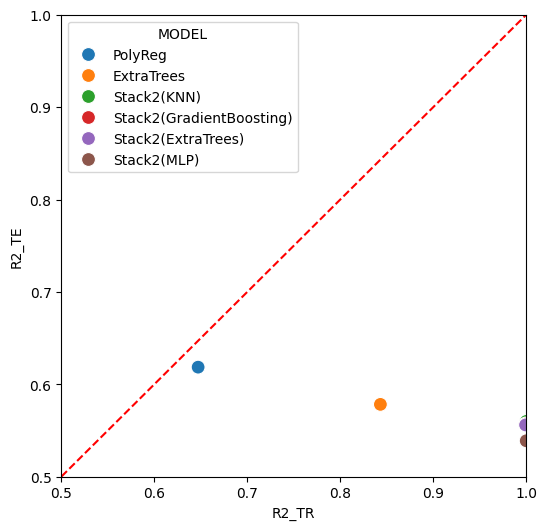

In [60]:
lim = (0.5, 1)
fsize = (6, 6)

plt.figure(figsize=fsize)
sns.scatterplot(data=df_results.loc[:5,:], y='R2_TE', x='R2_TR', hue='MODEL', s=100, palette='tab10')
plt.plot([0,1],[0,1], 'r--')
plt.xlim(lim)
plt.ylim(lim)

In [61]:
best_model = df_results.loc[0,'MODEL']
y_hat = df_results.loc[0,'MODEL_OBJ'].predict(X_te)

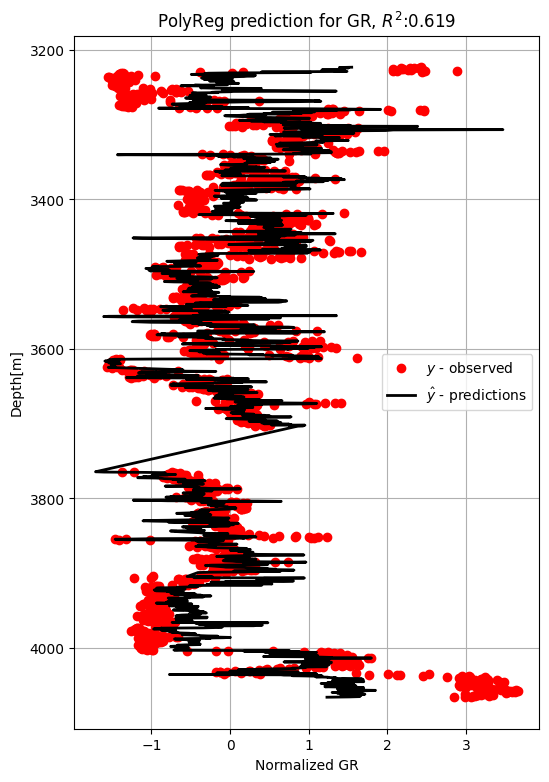

In [62]:
plt.figure(figsize=(6,9))
plt.plot(y_te,test_df['MD'],'ro')
plt.plot(y_hat,test_df['MD'], 'k', lw=2)
plt.gca().invert_yaxis()
plt.title(f'{best_model} prediction for {output[0]}, $R^2$:{r2_score(y_te, y_hat):.3f}')
plt.xlabel(f'Normalized {output[0]}')
plt.ylabel('Depth[m]')
plt.legend(['$y$ - observed','$\hat{y}$ - predictions'])
plt.grid()


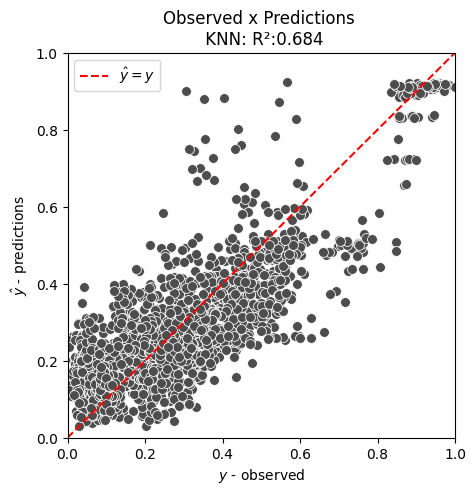

In [100]:
fig = plt.figure(figsize=(5,5))
# fig = plt.figure(figsize=(12,12))
lim =(0,1)

sns.scatterplot(x=y_te.ravel(), y=y_hat.ravel(), s=50, color='.3')
# sns.kdeplot(x=y_te.ravel(), y=y_hat.ravel(), levels=10, linewidths=1, thresh=0.01, color='grey')

plt.plot(lim, lim, 'r--', label='$\hat{y}=y$')
plt.xlim(lim)
plt.ylim(lim)

plt.xlabel('$y$ - observed')
plt.ylabel('$\hat{y}$ - predictions')

plt.legend(loc='upper left')

plt.title(f"Observed x Predictions \n {df_results.loc[0,'MODEL']}: R²:{df_results.loc[0,'R2_TE']:.3f}")

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '7_crossplot_y_yhat.eps')
# fig.savefig(p, format='eps')
pass;


In [69]:
prefix = 'REG_GR_FILT'
binary = os.path.join(os.getcwd(), 'Outputs', f'{prefix}.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump(df_results, bin_file)

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\Mestrado\SYSID_well_logs\Outputs\REG_GR_FILT.pkl
